# Baseline Sensitivity Study for a pulse of 7keK without noise



In [1]:
# ----IMPORT MODULES --------------
from __future__ import print_function
from __future__ import division
from multiprocessing import Pool, cpu_count
from itertools import repeat
from subprocess import check_call, check_output,STDOUT
from cycler import cycler
from astropy.io import fits
from scipy.stats import norm
from statistics import mean
import math
import sys, os
import shutil, tempfile, shlex
import re
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy.polynomial import Polynomial
import auxpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
eurecaDir = "/dataj6/ceballos/INSTRUMEN/EURECA"
sixteDir = eurecaDir + "/testHarness/simulations/SIXTE"
sixteInst = os.environ["SIXTE"] + "/share/sixte/instruments/athena-xifu/"
sixteInst = "/dataj4/software/SIXTE/git/gitInstall" + "/share/sixte/instruments/athena-xifu/"
xmlfile = sixteInst + "/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml"


# Define variables 

In [16]:
pulseLength=(128,256,512,1024,1500,2048,2500,3000,3500,4096,4500, 5000, 5500, 6000,7000, 8192) # or shorter lengths
ofLength=(128,256,512,1024,2048,4096,8192) # for 0-padding or shorter filters otherwise


# ... and filenames

In [17]:
name = "pulse7keVnonoise"
name_TBhigher = "pulse7keVnonoise_TBhigher"

inputFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + ".fits"
inputFile_TBhigher = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name_TBhigher + ".fits"

libfile = "/dataj6/ceballos/INSTRUMEN/EURECA/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL8192_20000p_jitter_bbfb.fits"
#xmlfile = "/home/EURECA/share/sixte/instruments/athena-xifu/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml"

# a) Filenames for 0-padding 
# ========================================================
evtFs = list()
evtFs_calib = list()
evtTBFs = list()
evtTBFs_calib = list()

for i in range(0,len(pulseLength)):    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_pL" + str(pulseLength[i]) + ".fits")
    #print(file)
    evtFs.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_pL" + str(pulseLength[i]) + "_HR.calib")
    #print(file)
    evtFs_calib.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_TBhigher_pL" + str(pulseLength[i]) + ".fits")
    #print(file)
    evtTBFs.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_TBhigher_pL" + str(pulseLength[i]) + "_HR.calib")
    #print(file)
    evtTBFs_calib.append(file)

# a) Optimal Filtering
# =============================
evtFs_OPTFILT = list()
evtFs_calib_OPTFILT = list()
evtTBFs_OPTFILT = list()
evtTBFs_calib_OPTFILT = list()

for i in range(0,len(ofLength)):    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_OPTFILT" + str(ofLength[i]) + ".fits")
    #print(file)
    evtFs_OPTFILT.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_OPTFILT" + str(ofLength[i]) + "_HR.calib")
    #print(file)
    evtFs_calib_OPTFILT.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_TBhigher_OPTFILT" + str(ofLength[i]) + ".fits")
    #print(file)
    evtTBFs_OPTFILT.append(file)
    
    file = ("/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/" + name + "_TBhigher_OPTFILT" + str(ofLength[i]) + "_HR.calib")
    #print(file)
    evtTBFs_calib_OPTFILT.append(file)

# Run 0-padding


In [18]:
# RECONSTRUCT by using 0-padding
run = 1
if run:
    for i in range(0,len(pulseLength)):
        if not os.path.isfile(evtFs[i]):
            comm = ("tesreconstruction Recordfile=" + inputFile + " TesEventFile=" + evtFs[i] + " Rcmethod=SIRENA" + 
                " PulseLength="+ str(pulseLength[i]) + " LibraryFile=" + libfile +
                " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
                " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
                " LagsOrNot=1" +
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=8192")
            try:
                print("Reconstructing: ", evtFs[i])
                print(comm)
                args = shlex.split(comm)
                check_call(args, stderr=STDOUT)
            except:
                print("Error running tool for SIRENA reconstruction with command:\n", comm)
                shutil.rmtree(tmpDir)
                raise
        if not os.path.isfile(evtTBFs[i]):
            comm = ("tesreconstruction Recordfile=" + inputFile_TBhigher + " TesEventFile=" + evtTBFs[i] + " Rcmethod=SIRENA" + 
                " PulseLength="+ str(pulseLength[i]) + " LibraryFile=" + libfile +
                " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
                " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
                " LagsOrNot=1" +
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=8192")
            try:
                print("Reconstructing: ", evtTBFs[i])
                print(comm)
                args = shlex.split(comm)
                check_call(args, stderr=STDOUT)
            except:
                print("Error running tool for SIRENA reconstruction with command:\n", comm)
                shutil.rmtree(tmpDir)
                raise

Reconstructing:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL1500.fits
tesreconstruction Recordfile=/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise.fits TesEventFile=/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL1500.fits Rcmethod=SIRENA PulseLength=1500 LibraryFile=/dataj6/ceballos/INSTRUMEN/EURECA/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL8192_20000p_jitter_bbfb.fits samplesUp=3 nSgms=3.5 samplesDown=4 opmode=1 OFLib=yes FilterDomain=T detectionMode=STC Fitting35=3 FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT LagsOrNot=1 XMLFile=/dataj4/software/SIXTE/git/gitInstall/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml filtEeV=6000.0 OFStrategy=FIXED OFLength=8192
Reconstructing:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_pL1500.fits
tesre

Reconstructing:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL5500.fits
tesreconstruction Recordfile=/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise.fits TesEventFile=/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_pL5500.fits Rcmethod=SIRENA PulseLength=5500 LibraryFile=/dataj6/ceballos/INSTRUMEN/EURECA/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL8192_20000p_jitter_bbfb.fits samplesUp=3 nSgms=3.5 samplesDown=4 opmode=1 OFLib=yes FilterDomain=T detectionMode=STC Fitting35=3 FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT LagsOrNot=1 XMLFile=/dataj4/software/SIXTE/git/gitInstall/share/sixte/instruments/athena-xifu//xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml filtEeV=6000.0 OFStrategy=FIXED OFLength=8192
Reconstructing:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/baselineSensitivity/pulse7keVnonoise_TBhigher_pL5500.fits
tesre

# Run OPTIMAL FILTER


In [5]:
# RECONSTRUCT by using OPTIMAL FILTERING
run = 0
if run:
    for i in range(0,len(ofLength)):
        comm = ("tesreconstruction Recordfile=" + inputFile + " TesEventFile=" + evtFs_OPTFILT[i] + " Rcmethod=SIRENA" + 
            " PulseLength=8192" + " LibraryFile=" + libfile +
            " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
            " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
            " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
            " LagsOrNot=1" +
            " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(ofLength[i]))
        try:
            print("Reconstructing: ", evtFs_OPTFILT[i])
            print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for SIRENA reconstruction with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise
                
        comm = ("tesreconstruction Recordfile=" + inputFile_TBhigher + " TesEventFile=" + evtTBFs_OPTFILT[i] + " Rcmethod=SIRENA" + 
            " PulseLength=8192" + " LibraryFile=" + libfile +
            " samplesUp=3" + " nSgms=3.5" + " samplesDown=4" + 
            " opmode=1 OFLib=yes FilterDomain=T" + " detectionMode=STC Fitting35=3" + 
            " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT" + 
            " LagsOrNot=1" +
            " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(ofLength[i]))
        try:
            print("Reconstructing: ", evtTBFs_OPTFILT[i])
            print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for SIRENA reconstruction with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise

# CALIBRATE 0-padding files


In [6]:
run = 0
if run:
    coeffsFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat"
    for i in range(0,len(pulseLength)):
        alias = "pL" + str(pulseLength[i]) + "_STC_T_fixedlib6OF_OPTFILT8192_jitter_bbfb"
        auxpy.convertEnergies(evtFs[i],evtFs_calib[i],coeffsFile,alias)
        
        auxpy.convertEnergies(evtTBFs[i],evtTBFs_calib[i],coeffsFile,alias)

# CALIBRATE OPTIMAL FILTERING files


In [7]:
run = 0
if run:
    coeffsFile = "/dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um_xifusim/coeffs_polyfit.dat"
    for i in range(0,len(ofLength)):
        alias = "pL8192_STC_T_fixedlib6OF_OPTFILT" + str(ofLength[i]) + "_jitter_bbfb"
        auxpy.convertEnergies(evtFs_OPTFILT[i],evtFs_calib_OPTFILT[i],coeffsFile,alias)
        
        auxpy.convertEnergies(evtTBFs_OPTFILT[i],evtTBFs_calib_OPTFILT[i],coeffsFile,alias)

# Plot the OPTIMAL FILTERING baseline sensitivity

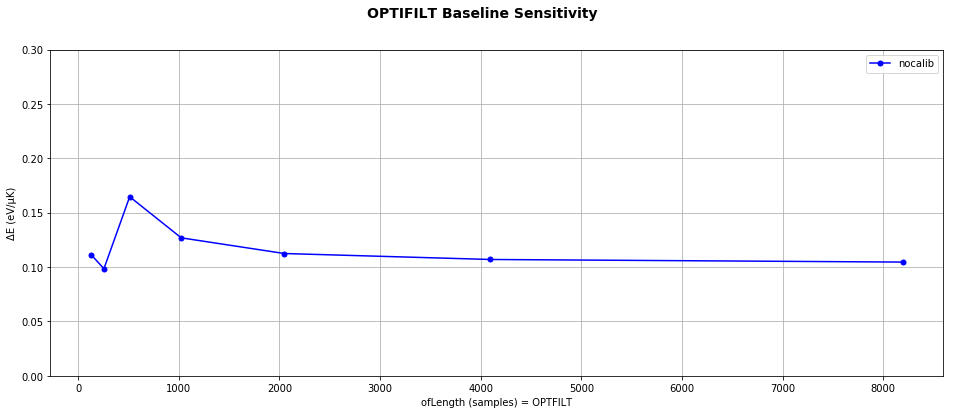

In [19]:
run = 1
if run:
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('OPTIFILT Baseline Sensitivity', fontsize=14, fontweight='bold')
    
    # No calibrated
    nocalib_OPTFILT = list()
    TBhigher_nocalib_OPTFILT = list()
    
    calib_OPTFILT = list()
    TBhigher_calib_OPTFILT = list()
    
    for i in range (0,len(ofLength)):
        file = fits.open(evtFs_OPTFILT[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        nocalib_OPTFILT.append(fileSIGNAL[0])
    
        file = fits.open(evtTBFs_OPTFILT[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        TBhigher_nocalib_OPTFILT.append(fileSIGNAL[0])
        
        #file = fits.open(evtFs_calib_OPTFILT[i], memmap=True)
        #fileTab = file[1].data
        #fileSIGNAL = fileTab['SIGNAL']
        #file.close()
        
        #calib_OPTFILT.append(fileSIGNAL[0])
    
        #file = fits.open(evtTBFs_calib_OPTFILT[i], memmap=True)
        #fileTab = file[1].data
        #fileSIGNAL = fileTab['SIGNAL']
        #file.close()
        
        #TBhigher_calib_OPTFILT.append(fileSIGNAL[0])
        
    AE_eV_nocalib_OPTFILT = list()
    #AE_eV_calib_OPTFILT = list()
    for i in range(0,len(ofLength)):
        AE_eV_nocalib_OPTFILT.append(abs(nocalib_OPTFILT[i]-TBhigher_nocalib_OPTFILT[i])*1e3/0.1) # +0.1uK TBhigher with respect to TB=55mK
        #AE_eV_calib_OPTFILT.append(abs(calib_OPTFILT[i]-TBhigher_calib_OPTFILT[i])*1e3/0.1) # +0.1uK TBhigher with respect to TB=55mK
    
    plt.plot(ofLength,AE_eV_nocalib_OPTFILT, marker='o', linestyle='solid', ms=5,label='nocalib',color='blue')
    #plt.plot(ofLength,AE_eV_calib_OPTFILT, marker='v', linestyle='dotted', ms=5,label='calib',color='blue')
    #plt.plot(512,(3.17370410616157-3.17360568817963)*1e3,'or',  ms=5,label='Sum0Filt=1 nocalib')
    #plt.plot(512,(6.99757955314489-6.99718615454381)*1e3, 'vr',  ms=5,label='Sum0Filt=1 calib')
    
    plt.legend()
    plt.ylabel('ΔE (eV/µK)')
    plt.xlabel('ofLength (samples) = OPTFILT')
    plt.grid(True)

    plt.ylim(0.,0.3)

    plt.show()
    

# Plot the 0-padding baseline sensitivity

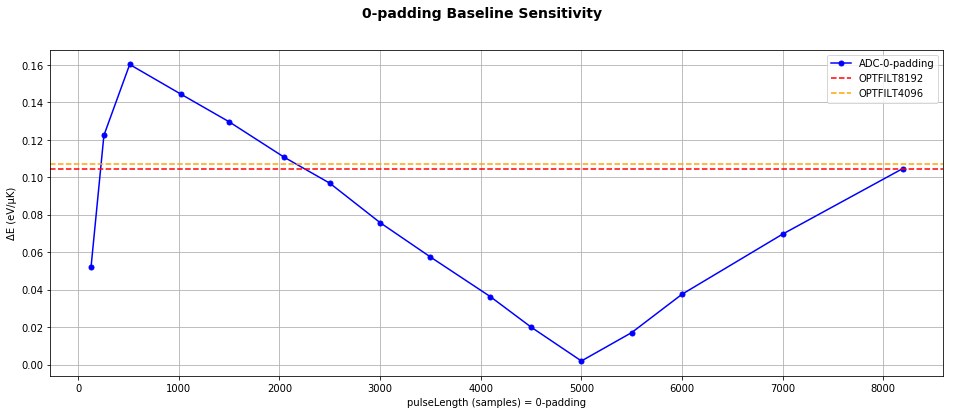

ΔE 0-padding( 128 ): 0.05201245091512874  eV => 0.0010048515235703132 %
ΔE 0-padding( 256 ): 0.12237538424386685  eV => 0.001782467416122949 %
ΔE 0-padding( 512 ): 0.1601900111314336  eV => 0.0022552134992001294 %
ΔE 0-padding( 1024 ): 0.14425081417357433  eV => 0.002036798379227487 %
ΔE 0-padding( 1500 ): 0.12959250204502837  eV => 0.001834769233900096 %
ΔE 0-padding( 2048 ): 0.1106592986666044  eV => 0.0015721999777440086 %
ΔE 0-padding( 2500 ): 0.096828209130706  eV => 0.0013792223538007604 %
ΔE 0-padding( 3000 ): 0.07577137552949864  eV => 0.0010835195568510703 %
ΔE 0-padding( 3500 ): 0.05743828329407563  eV => 0.0008241720015648382 %
ΔE 0-padding( 4096 ): 0.03625454265687722  eV => 0.0005222769911126694 %
ΔE 0-padding( 4500 ): 0.02002244657184349  eV => 0.00028932087695079207 %
ΔE 0-padding( 5000 ): 0.001938291323000385  eV => 2.8103583716254204e-05 %
ΔE 0-padding( 5500 ): 0.017103778340299414  eV => 0.00024888494650103277 %
ΔE 0-padding( 6000 ): 0.0375622860993019  eV => 0.000548

In [27]:
run = 1
if run:
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('0-padding Baseline Sensitivity', fontsize=14, fontweight='bold')
    
    # No calibrated
    nocalib = list()
    TBhigher_nocalib = list()
    
    calib = list()
    TBhigher_calib = list()
    
    for i in range (0,len(pulseLength)):
        file = fits.open(evtFs[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        nocalib.append(fileSIGNAL[0])
    
        file = fits.open(evtTBFs[i], memmap=True)
        fileTab = file[1].data
        fileSIGNAL = fileTab['SIGNAL']
        file.close()
        
        TBhigher_nocalib.append(fileSIGNAL[0])
        
        #file = fits.open(evtFs_calib[i], memmap=True)
        #fileTab = file[1].data
        #fileSIGNAL = fileTab['SIGNAL']
        #file.close()
        
        #calib.append(fileSIGNAL[0])
    
        #file = fits.open(evtTBFs_calib[i], memmap=True)
        #fileTab = file[1].data
        #fileSIGNAL = fileTab['SIGNAL']
        #file.close()
        
        #TBhigher_calib.append(fileSIGNAL[0])
        
    AE_eV_nocalib = list()
    AE_eV_nocalib_rel = list()
    AE_eV_calib = list()
    for i in range(0,len(pulseLength)):
        AE_eV_nocalib.append(abs(nocalib[i]-TBhigher_nocalib[i])*1e3/0.1) # +0.1uK TBhigher with respect to TB=55mK
        AE_eV_nocalib_rel.append(100*AE_eV_nocalib[i]/(nocalib[i]*1e3))
        #AE_eV_calib.append(abs(calib[i]-TBhigher_calib[i])*1e3/0.1) # +0.1uK TBhigher with respect to TB=55mK
    
    plt.plot(pulseLength,AE_eV_nocalib, marker='o', linestyle='solid', ms=5,label='ADC-0-padding',color='blue')
    #plt.plot(pulseLength,AE_eV_calib, marker='v', linestyle='dotted', ms=5,label='calib',color='blue')
    #plt.plot(512,(3.17370410616157-3.17360568817963)*1e3,'or',  ms=5,label='Sum0Filt=1 nocalib')
    #plt.plot(512,(6.99757955314489-6.99718615454381)*1e3, 'vr',  ms=5,label='Sum0Filt=1 calib')
    #plt.plot(8192,AE_eV_nocalib_OPTFILT[6], 'vr',  ms=5,label='8192 OPTFILT')
    plt.axhline(y=AE_eV_nocalib_OPTFILT[6],linestyle='--',color='red',label="OPTFILT8192")
    plt.axhline(y=AE_eV_nocalib_OPTFILT[5],linestyle='--',color='orange',label="OPTFILT4096")

    plt.legend()
    plt.ylabel('ΔE (eV/µK)')
    plt.xlabel('pulseLength (samples) = 0-padding')
    plt.grid(True)

    #plt.ylim(0.001,0.2)

    plt.show()
    #fig.savefig('baselineSensitivity0padding_zoom.png', dpi=fig.dpi)
    
    # plot differences in %
    #------------------------
    #plt.plot(pulseLength,AE_eV_nocalib_rel, marker='o', linestyle='solid', ms=5,label='ADC-0-padding',color='blue')
    #plt.legend()
    #plt.ylabel('ΔE/E (%)')
    #plt.xlabel('pulseLength (samples) = 0-padding')
    #plt.grid(True)
    #plt.show()
    for il in range(0,len(pulseLength)):
        print("ΔE 0-padding(",pulseLength[il],"):",AE_eV_nocalib[il],
              " eV =>",AE_eV_nocalib[il]/(nocalib[il]*1e3)*100,"%")
    print("ΔE(8192)OPTFILT:",AE_eV_nocalib_OPTFILT[-1]," eV =>",
          AE_eV_nocalib_OPTFILT[-1]/(nocalib_OPTFILT[-1]*1e3)*100,"%")
    